In [3]:
import re
from dataclasses import dataclass
from typing import List, Optional, Any, Dict, Tuple

## Lexer

In [4]:
TokenSpec = [
    ("NUMBER",      r"\d+"),
    ("NOTE",        r"[A-G](?:#|b)?\d"),        # e.g., C4, F#3, Bb5
    ("DURATION",    r"whole|half|quarter|eighth|sixteenth"), # common durations
    ("SET",         r"Set\b|set\b"),
    ("KEY",         r"key\b|Key\b"),
    ("TIME",        r"time\b|Time\b"),
    ("SIGNATURE",   r"signature\b|Signature\b"),
    ("TEMPO",       r"tempo\b|Tempo\b"),
    ("IN",          r"In\b|in\b"),
    ("MEASURE",     r"measure\b|Measure\b"),
    ("TO",          r"to\b|To\b"),
    ("COLON",       r":"),
    ("COMMA",       r","),
    ("SLASH",       r"/"),
    ("IDENT",       r"[A-Za-z+#]+"),            # words like 'C', 'major', 'minor'
    ("NEWLINE",     r"\n"),
    ("WS",          r"[ \t]+"),
    ("UNKNOWN",     r"."),
]
tok_regex = "|".join(f"(?P<{name}>{pattern})" for name, pattern in TokenSpec)

@dataclass
class Token:
    type: str
    value: str
    pos: int

In [5]:
class Lexer:
    def __init__(self, text: str):
        self.text = text
        self.pos = 0
        self.tokens: List[Token] = []

    def tokenize(self) -> List[Token]:
        for m in re.finditer(tok_regex, self.text):
            kind = m.lastgroup
            value = m.group()
            pos = m.start()
            if kind == "WS" or kind == "NEWLINE":
                continue
            if kind == "UNKNOWN":
                raise SyntaxError(f"Unknown token {value!r} at pos {pos}")
 
            tok = Token(kind, value, pos)
            self.tokens.append(tok)
        self.tokens.append(Token("EOF", "", len(self.text)))
        return self.tokens

### Testing tokens

In [6]:
sample = """
    Set key to C minor
    Set time signature to 4/4
    Set tempo to 120

    In measure 1:
        C4 quarter, E4 quarter, G4 half

    In measure 2:
        F4 quarter, A4 quarter, C5 half
        
    In measure 3:
        D4 quarter, F4 quarter, A4 half
    """
lexer = Lexer(sample.strip())
tokens = lexer.tokenize()
for token in tokens:
    print(token)

Token(type='SET', value='Set', pos=0)
Token(type='KEY', value='key', pos=4)
Token(type='TO', value='to', pos=8)
Token(type='IDENT', value='C', pos=11)
Token(type='IDENT', value='minor', pos=13)
Token(type='SET', value='Set', pos=23)
Token(type='TIME', value='time', pos=27)
Token(type='SIGNATURE', value='signature', pos=32)
Token(type='TO', value='to', pos=42)
Token(type='NUMBER', value='4', pos=45)
Token(type='SLASH', value='/', pos=46)
Token(type='NUMBER', value='4', pos=47)
Token(type='SET', value='Set', pos=53)
Token(type='TEMPO', value='tempo', pos=57)
Token(type='TO', value='to', pos=63)
Token(type='NUMBER', value='120', pos=66)
Token(type='IN', value='In', pos=75)
Token(type='MEASURE', value='measure', pos=78)
Token(type='NUMBER', value='1', pos=86)
Token(type='COLON', value=':', pos=87)
Token(type='NOTE', value='C4', pos=97)
Token(type='DURATION', value='quarter', pos=100)
Token(type='COMMA', value=',', pos=107)
Token(type='NOTE', value='E4', pos=109)
Token(type='DURATION', valu

## Parser

In [7]:
class Parser:
    def __init__(self, tokens):
        self.tokens = tokens
        self.pos = 0

    def peek(self):
        if self.pos < len(self.tokens):
            return self.tokens[self.pos]
        return None
    
    def eat(self, expected_type=None):
        token = self.peek()
        if token is None:
            raise SyntaxError("Unexpected end of input")    
        if expected_type and token.type != expected_type:
            raise SyntaxError(f"Expected token type {expected_type}, got {token.type}")
        self.pos += 1
        return token
    
    def parse_list(self):
        statements = []
        while self.peek().type != "EOF":
            statements.append(self.parse_statement())
        return ("list", statements)
    
    def parse_statement(self):
        token = self.peek()
        if token.type == "SET":
            self.eat("SET")
            next_tok = self.peek()
            if next_tok.type == "KEY":
                return self.parse_set_key_stmt()
            elif next_tok.type == "TIME":
                return self.parse_set_time_signature_stmt()
            elif next_tok.type == "TEMPO":
                return self.parse_set_tempo_stmt()
            else:
                raise SyntaxError(f"Unexpected token {next_tok.type} after SET")
        
        elif token.type == "IN":
            self.eat("IN")
            return self.parse_measure_stmt()
        else:
            raise SyntaxError(f"Unexpected statement start: {token.type}")
        
    def parse_set_key_stmt(self):
        self.eat("KEY")
        self.eat("TO")
        key_name = self.eat("IDENT").value
        mode = self.eat("IDENT").value
        return ("set_key", key_name, mode)
    
    def parse_set_time_signature_stmt(self):
        self.eat("TIME")
        self.eat("SIGNATURE")
        self.eat("TO")
        numerator = int(self.eat("NUMBER").value)
        self.eat("SLASH")
        denominator = int(self.eat("NUMBER").value)
        return ("set_time_signature", numerator, denominator)
    
    def parse_set_tempo_stmt(self):
        self.eat("TEMPO")
        self.eat("TO")
        bpm = int(self.eat("NUMBER").value)
        return ("set_tempo", bpm)

    def parse_measure_stmt(self):
        self.eat("MEASURE")
        measure_num = int(self.eat("NUMBER").value)
        self.eat("COLON")
        notes = []
        self.parse_note_list(notes)
        return ("measure", measure_num, notes)      
    
    def parse_note_list(self, notes):
        notes.append(self.parse_note_entry())
        while self.peek() and self.peek().type == "COMMA":
            self.eat("COMMA")
            notes.append(self.parse_note_entry())
        return notes
    
    def parse_note_entry(self):
        note = self.eat("NOTE").value
        duration = self.eat("DURATION").value
        return ("note", note, duration)

In [8]:
parser = Parser(tokens)
ast = parser.parse_list()
print(ast)

('list', [('set_key', 'C', 'minor'), ('set_time_signature', 4, 4), ('set_tempo', 120), ('measure', 1, [('note', 'C4', 'quarter'), ('note', 'E4', 'quarter'), ('note', 'G4', 'half')]), ('measure', 2, [('note', 'F4', 'quarter'), ('note', 'A4', 'quarter'), ('note', 'C5', 'half')]), ('measure', 3, [('note', 'D4', 'quarter'), ('note', 'F4', 'quarter'), ('note', 'A4', 'half')])])


## Semantic Analyzer

In [14]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'

In [17]:

class Semantic_Analyzer:
    def __init__(self, ast):
        self.ast = ast
        self.key = None
        self.time_signature = None
        self.tempo = None
        self.measures = {}

        self.score = stream.Score()
        self.part = stream.Part()
        self.score.append(self.part)
    
    def analyze(self):
        if self.ast[0] != "list":
            raise ValueError("AST must be a list of statements")
        
        for stmt in self.ast[1]:
            self.analyze_statement(stmt)
        
        self.score.write('musicxml', fp='output.xml')
        self.score.show('midi')
        self.score.show()
    
    def analyze_statement(self, stmt):
        if stmt[0] == "set_key":
            _, key_name, mode = stmt
            self.key = (key_name, mode)
            self.part.append(key.Key(key_name, mode))
        
        elif stmt[0] == "set_time_signature":
            _, numerator, denominator = stmt
            self.time_signature = (numerator, denominator)
            self.part.append(meter.TimeSignature(f"{numerator}/{denominator}"))
        
        elif stmt[0] == "set_tempo":
            _, bpm = stmt
            self.tempo = bpm
            self.part.append(tempo.MetronomeMark(number=bpm))
        
        elif stmt[0] == "measure":
            _, measure_num, notes = stmt

            if measure_num in self.measures:
                raise ValueError(f"Duplicate measure number: {measure_num}")
            
            m = stream.Measure(number=measure_num)
            for note_entry in notes:
                _, pitch, dur = note_entry
                n = note.Note(pitch)
                n.duration.type = dur
                m.append(n)
            self.measures[measure_num] = notes
            self.part.append(m)
           
        
        

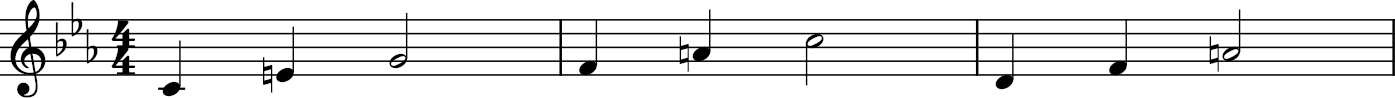

In [18]:
interpreter = Semantic_Analyzer(ast)
interpreter.analyze()

## Output

The output for this interpreter uses the *music21* library

In [13]:
from music21 import *

# Sample output using music21
n1 = note.Note("C4")
n1.duration.type="whole"
n2 = note.Note("A4")
n2.duration.type="16th"

stream=stream.Stream()

stream.timeSignature = meter.TimeSignature('6/4')
stream.keySignature = key.KeySignature(0) # set key to C major
stream.tempo = tempo.MetronomeMark(number=120) # set tempo to 120 BPM

stream.append([n1,n2])

stream.show()

#Writing as xml for MuseScore
stream.write("musicxml",fp="test.xml")


PermissionError: [WinError 5] Access is denied